# MNIST classifier from nnBuilder

This is a better implementation of a MNIST classifier using the nnBuilder framework, reaching 0.35-0.40% error rate. The error could be further reduced with better input preprocessing and by using a committee of networks.

The network consists of two convolutional and three fully connected layers. The input is randomly cropped to 24x24 pixels, and a small uniform noise is applied before each layer (combined with batch normalization). The network is optimized using an Adam optimizer.

In [1]:
import numpy as np
import tensorflow as tf
import sys, os, seaborn, time
import matplotlib.pyplot as plt
sys.path.append('../nnBuilder')
from nnLayer import *
from nnInput import *
from nnTrainer import *
from nnHandler import *

In [2]:
test_split_n=10 #Use less memory
data=Layer(type="MNIST",batch=128,out_features=[dict(type="Batch_Random_Crop",shape=[24,24,1])])
data_test=Layer(type="MNIST",test=True)
data_test=Layer(x=data_test,type="Batch_Slice",batch=10000//test_split_n,out_features=[dict(type="Central_Crop",shape=[24,24])])
noise=dict(type="Noise",rand_type="uniform",scale=0.2,drop_on_test=True)
batch_norm=dict(type="Batch_Norm")
layers=[]
layers.append(dict(type="Convolution",pad="SAME",window=5,stride=1,size=64,relu=True,in_features=[noise]))
layers.append(dict(type="Pool",pad="SAME",window=2,stride=2,pool_type="max",out_features=[batch_norm]))
layers.append(dict(type="Convolution",pad="SAME",window=5,stride=1,size=128,relu=True,in_features=[noise]))
layers.append(dict(type="Pool",pad="SAME",window=2,stride=2,pool_type="max",out_features=[batch_norm]))
layers.append(dict(type="Relu",size=256,in_features=[noise],out_features=[batch_norm]))
layers.append(dict(type="Relu",size=128,in_features=[noise],out_features=[batch_norm]))
layers.append(dict(type="Linear",size=10,in_features=[dict(type="Dropout")]))
network_def=dict(type="Network",layers=layers)
network=Layer(x=data,**network_def)
network_eval=network.copy(x=data,share_vars=True,test=True)
network_test=network.copy(x=data_test,share_vars=True,test=True)
trainer=ClassifierTrainer(network=network,optimizer="adam")
trainer_eval=ClassifierTrainer(network=network_eval,test=True)
tester=ClassifierTrainer(network=network_test,test=True)
sess=SessManager(data,network,trainer,data_test,network_test,tester,network_eval,trainer_eval)

Extracting /tmp/tensorflow/mnist/input_data\train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-labels-idx1-ubyte.gz


Error rate (train): 0.904141
Error rate (test): 0.904063
Error rate (test): 0.912


<IPython.core.display.Javascript object>


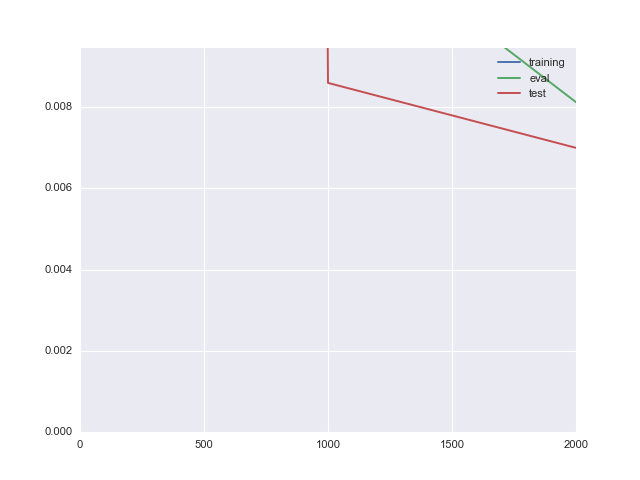

Error rate (train): 0.0164844
Error rate (eval): 0.0128125
Error rate (test): 0.0086
Error rate (train): 0.01125
Error rate (eval): 0.008125
Error rate (test): 0.007


KeyboardInterrupt: 

In [3]:
batches_per_step=1000#60000//128 #About 1 epoch
batches_per_eval=100
n_steps=50
def make_plt():
    %matplotlib notebook
    global fig,ax,train_plot,test_plot,eval_plot
    fig,ax = plt.subplots(1,1)
    train_plot=ax.plot([],[], label="training")[0]
    eval_plot=ax.plot([],[], label="eval")[0]
    test_plot=ax.plot([],[], label="test")[0]
    ax.set_ylim(0,1)
    plt.legend()
    fig.canvas.draw()
    time.sleep(.01)
def update_plt():
    x=[batches_per_step*i for i in range(len(trains))]
    train_plot.set_xdata(x)
    train_plot.set_ydata(trains)
    test_plot.set_xdata(x)
    test_plot.set_ydata(tests)
    eval_plot.set_xdata(x)
    eval_plot.set_ydata(evals)
    ax.set_xlim(0,x[-1])
    ax.set_ylim(0,tests[1]*1.1)
    fig.canvas.draw()
    #time.sleep(.01)
if "trains" not in globals():
    trains=[trainer.eval_error(n=batches_per_eval)[1]]
    evals=[trainer_eval.eval_error(n=batches_per_eval)[1]]
    tests=[tester.eval_error()[1]]
make_plt()
for i in range(n_steps):
    if i>10:
        r=1e-5
    elif i>5:
        r=1e-4
    else:
        r=1e-3
    trainer.train(batches_per_step,keep_rate=0.5,l2reg=1e-6,learn_rate=r)
    trains.append(trainer.eval_error(n=batches_per_eval)[1]) #Training error, reaches < 0.1%
    evals.append(trainer_eval.eval_error(n=batches_per_eval,info="eval")[1]) 
    tests.append(tester.eval_error(n=test_split_n)[1])#Testing error, reaches 0.35-0.4%
    update_plt()

In [5]:
network.save() #The full network definition

{'layers': [{'in_features': [{'drop_on_test': True,
     'rand_type': 'uniform',
     'scale': 0.2,
     'type': 'Noise'}],
   'pad': 'SAME',
   'relu': True,
   'size': 64,
   'stride': 1,
   'type': 'Convolution',
   'window': 5},
  {'out_features': [{'type': 'Batch_Norm'}],
   'pad': 'SAME',
   'pool_type': 'max',
   'stride': 2,
   'type': 'Pool',
   'window': 2},
  {'in_features': [{'drop_on_test': True,
     'rand_type': 'uniform',
     'scale': 0.2,
     'type': 'Noise'}],
   'pad': 'SAME',
   'relu': True,
   'size': 128,
   'stride': 1,
   'type': 'Convolution',
   'window': 5},
  {'out_features': [{'type': 'Batch_Norm'}],
   'pad': 'SAME',
   'pool_type': 'max',
   'stride': 2,
   'type': 'Pool',
   'window': 2},
  {'in_features': [{'drop_on_test': True,
     'rand_type': 'uniform',
     'scale': 0.2,
     'type': 'Noise'}],
   'out_features': [{'type': 'Batch_Norm'}],
   'size': 256,
   'type': 'Relu'},
  {'in_features': [{'drop_on_test': True,
     'rand_type': 'uniform',
 